<a href="https://colab.research.google.com/github/MelikaKalbasi/knowledge-discovery/blob/main/HW1_resnetMelikaKalbasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install matplotlib==3.5 #with newer versions of matplotlib this notebook might not run
%matplotlib inline
!pip install captum==0.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
!pip install pytorch-gradcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import os
dset_dir = "/content/drive/MyDrive/AI/" 
os.listdir(dset_dir)

['submission.csv', 'test.csv', 'train.csv', 'train', 'test']

In [41]:
import os
import random
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
from torch.utils.data import random_split
from matplotlib import pyplot as plt
from numpy import asarray

import captum
from captum.attr import IntegratedGradients, LayerGradCam, LayerAttribution, NoiseTunnel
from captum.attr import visualization as viz
import time

from torchvision.models import resnet50, ResNet50_Weights

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision


In [20]:
Path(dset_dir)/"train"

PosixPath('/content/drive/MyDrive/AI/train')

In [21]:
class UnictImg(Dataset):
    def __init__(self, dset_dir, train=True,mask=False,res_bb_perc=0, transforms=None):
        
        self.split = "train" if train else "test"
        self.dset_dir = Path(dset_dir)/self.split
        self.transforms = transforms
        self.res_bb_perc=res_bb_perc
        self.mask=mask
        self.files = []
        self.df_bb=pd.DataFrame()
        self.df_bb=pd.read_csv(dset_dir+"train.csv")
        folders = sorted(os.listdir(self.dset_dir))
        self.file=folders
        if self.split=="train" :         
            for folder in folders:
                class_idx= folders.index(folder)
                folder_dir = self.dset_dir/folder
                files = os.listdir(folder_dir)
                if(class_idx==0):
                    self.files+=[{"mask":folder+"/"+x,"file": folder_dir/x, "class": class_idx+1,"flag":True} for x in files]
                    if(mask):
                        self.files+=[{"mask":folder+"/"+x,"file": folder_dir/x, "class": class_idx+1,"flag":True} for x in files]
                else:
                    self.files+=[{"mask":folder+"/"+x,"file": folder_dir/x, "class": class_idx+1,"flag":False} for x in files]
                    if(mask):
                        self.files+=[{"mask":folder+"/"+x,"file": folder_dir/x, "class": class_idx+1,"flag":False} for x in files]

        else:
            self.files+=[self.dset_dir/file for file in folders]
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        
        if self.split == "train":
            
            item = self.files[i]
            file = item['file']
            class_idx=item['class']
            # reading the images and converting them to correct size and color    
            img = cv2.imread(str(file))
            img_res = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
            # diving by 255
            img_res /= 255.0
            
            # recover bounding boxes
            name_file_img=item['mask']
            bb=self.df_bb[self.df_bb["image"]==name_file_img]
          
            # resize bounding boxes
            xmin=int(bb["x1"])+1
            ymin=int(bb["y1"])+1
            xmax=int(bb["x2"])-1
            ymax=int(bb["y2"])-1
            res_bb_perc=self.res_bb_perc
            boxes = [[xmin+((xmax-xmin)*res_bb_perc), 
                      ymin+((ymax-ymin)*res_bb_perc), 
                      xmax-((xmax-xmin)*res_bb_perc), 
                      ymax-((ymax-ymin)*res_bb_perc)]]           
           
                    
            labels = torch.tensor(item['class'],dtype=torch.int64)
            labels=labels.unsqueeze(0)
                                    
            # applying transformations            
            sample = {'image' : img_res,
                      'bboxes' : boxes,
                      'labels' : labels}
               
            sample = self.transforms(**sample)
            target = {}
            target["boxes"] =torch.tensor(sample['bboxes'],dtype=torch.int64)
            target["labels"] = torch.tensor(sample['labels'],dtype=torch.int64)
            img_res = sample['image']
            
            if(self.mask and item['flag']):
                
                bb=target['boxes'][0]
                #creating masked image
                mask=torch.rand(3,224,224)
                mask[0:3,bb[1]:bb[3],bb[0]:bb[2]]= img_res[0:3,bb[1]:bb[3],bb[0]:bb[2]]
                img_res=mask
                
            if(self.mask):
                target["labels"] =  target["labels"]-1
                class_idx-=1
               
            return img_res, target,class_idx
        else:
            file = self.files[i]
            # reading the images and converting them to correct size and color    
            img = cv2.imread(str(file))
            img_res = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
            # diving by 255
            img_res /= 255.0
            
            sample = {'image': img_res}
            sample = self.transforms(**sample)
            image = sample['image']
           
            return image,self.file[i]
        


In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [42]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(1),
        A.Resize(224,224),
        A.ShiftScaleRotate(shift_limit=0.2,scale_limit=0.2, rotate_limit=45, p=0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform():
    return A.Compose([
        A.Resize(224,224),
        ToTensorV2(p=1.0)
    ])

In [43]:
dataset_resnet = UnictImg(dset_dir, train=True,mask=True,res_bb_perc=0.05, transforms= get_train_transform())

train_data_loader_resnet = DataLoader(
    dataset_resnet,
    batch_size=32,
    shuffle=True,
    num_workers=4,
)
test_dataset = UnictImg(dset_dir, train=False, transforms= get_test_transform())

In [25]:
model_resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

num_ftrs = model_resnet.fc.in_features
# Parameters of newly constructed modules have requires_grad=True by default
model_resnet.fc = nn.Linear(num_ftrs, 8)
model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(model_resnet.parameters(), lr=0.005, momentum=0.9)



In [26]:
num_epochs = 5  #(set no of epochs)
start_time = time.time() #(for showing time)
for epoch in range(num_epochs): #(loop for every epoch)
    start_time_epoch = time.time() #(for showing time)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model_resnet.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs,tar,labels) in enumerate(train_data_loader_resnet):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model_resnet(inputs)
        _, preds = torch.max(outputs, 1)
        
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / dataset_resnet.__len__()
    epoch_acc = running_corrects / dataset_resnet.__len__() * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))



Epoch 0 running
[Train #0] Loss: 0.4294 Acc: 85.4375% Time: 71.9618s
Epoch 1 running
[Train #1] Loss: 0.0400 Acc: 98.9688% Time: 110.0082s
Epoch 2 running
[Train #2] Loss: 0.0312 Acc: 99.0625% Time: 147.4067s
Epoch 3 running
[Train #3] Loss: 0.0231 Acc: 99.3438% Time: 185.9750s
Epoch 4 running
[Train #4] Loss: 0.0258 Acc: 99.2500% Time: 223.8203s


In [28]:
ls_image=[]
ls_class=[]
for idx in range(test_dataset.__len__()):
    inputs,name_file = test_dataset[idx]

    # put the model in evaluation mode
    model_resnet.eval()
    with torch.no_grad():
        inputs=inputs.to(device)
        outputs = model_resnet(inputs.unsqueeze(0))
    _, preds = torch.max(outputs, 1)
    
    ls_image.append(name_file)
    ls_class.append(int(preds.cpu()))
    
import pandas as pd

d = {'image': ls_image, 'class': ls_class}
df_resnet = pd.DataFrame(data=d)

df_resnet.to_csv("submission_resnet.csv",index=False)


In [35]:
def XAI(ds,index,train=False):
    if(train):
        img, tar,idx = ds[index]
    else:
         img, name_file = ds[index]
    model_resnet.eval()
    with torch.no_grad():
        inputs = img.unsqueeze(0).to(device)
        outputs = model_resnet(inputs)
    _, preds = torch.max(outputs, 1)
        
    print(int(preds))
    layer_gradcam = LayerGradCam(model_resnet, model_resnet.layer4[2].conv3)
    attributions_lgc = layer_gradcam.attribute(inputs, target=preds)

    upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, inputs.shape[2:])

    print(attributions_lgc.shape)
    print(upsamp_attr_lgc.shape)
    print(inputs.shape)

    _ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      img.permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","masked_image"],
                                      ["all","positive","positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))

7
torch.Size([1, 1, 7, 7])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


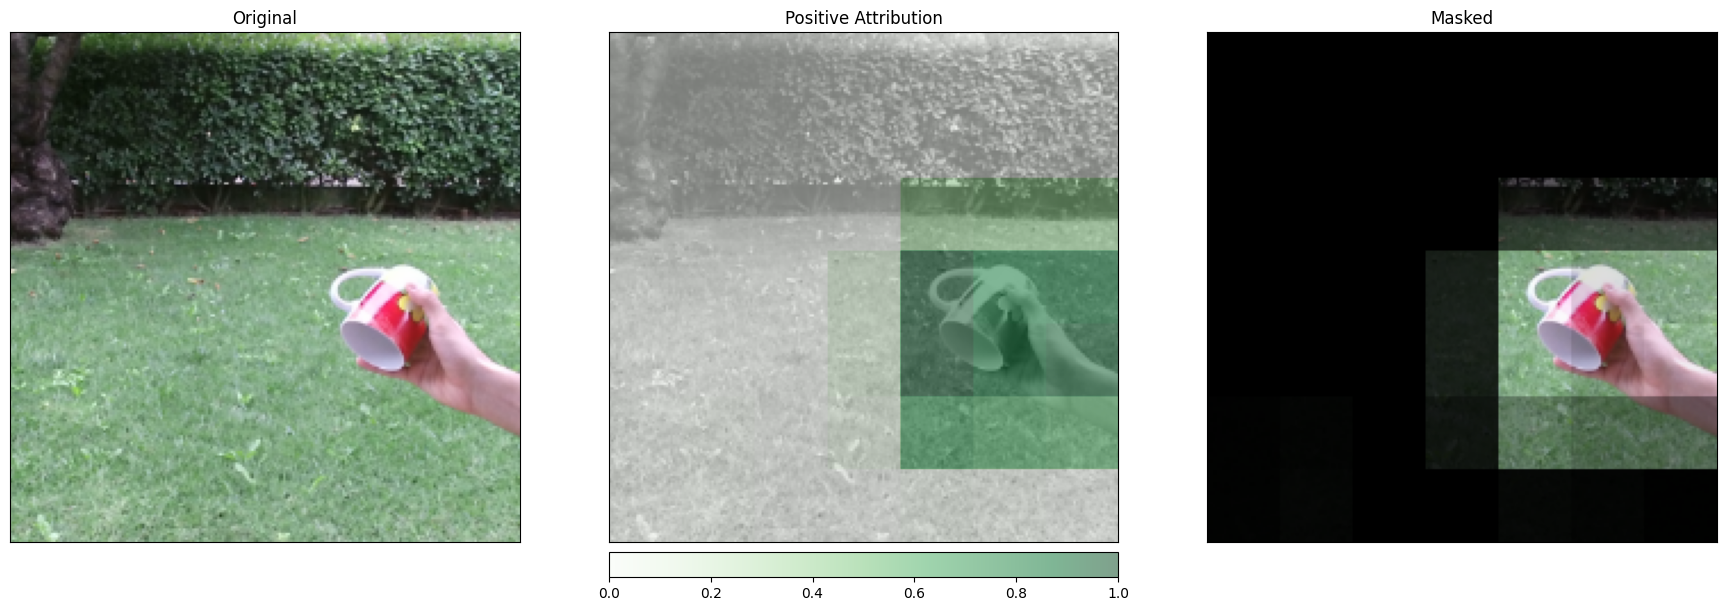

In [37]:
XAI(test_dataset,25)

4
torch.Size([1, 1, 7, 7])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


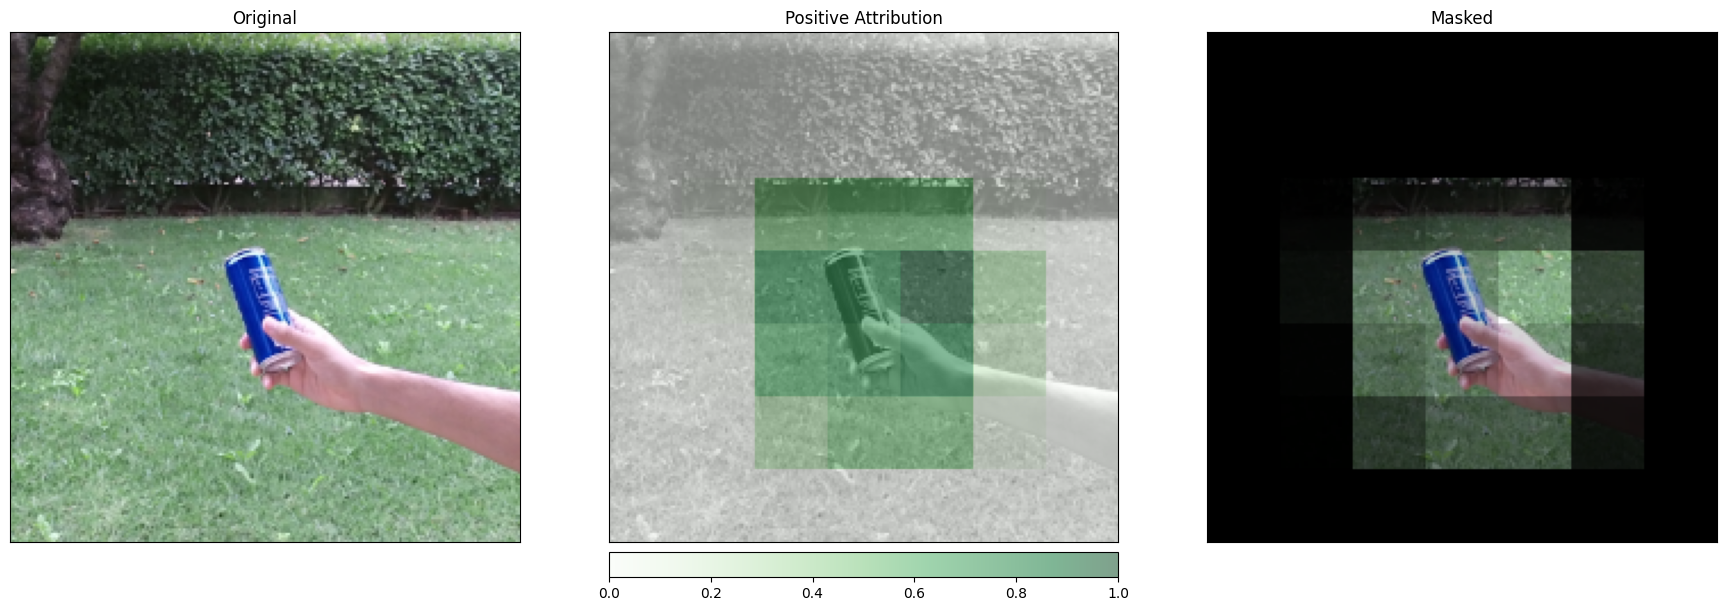

In [38]:
XAI(test_dataset,225)

7
torch.Size([1, 1, 7, 7])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


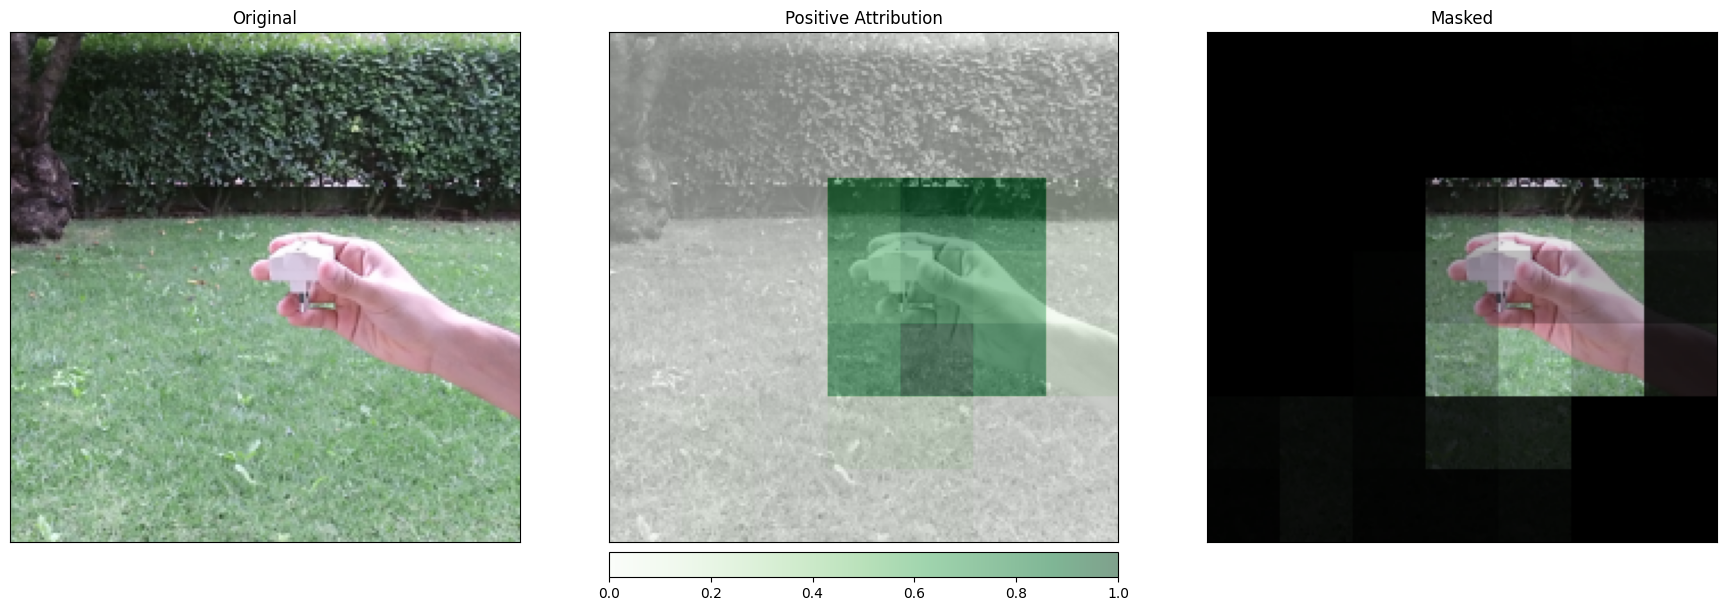

In [39]:
XAI(test_dataset,525)

1
torch.Size([1, 1, 7, 7])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


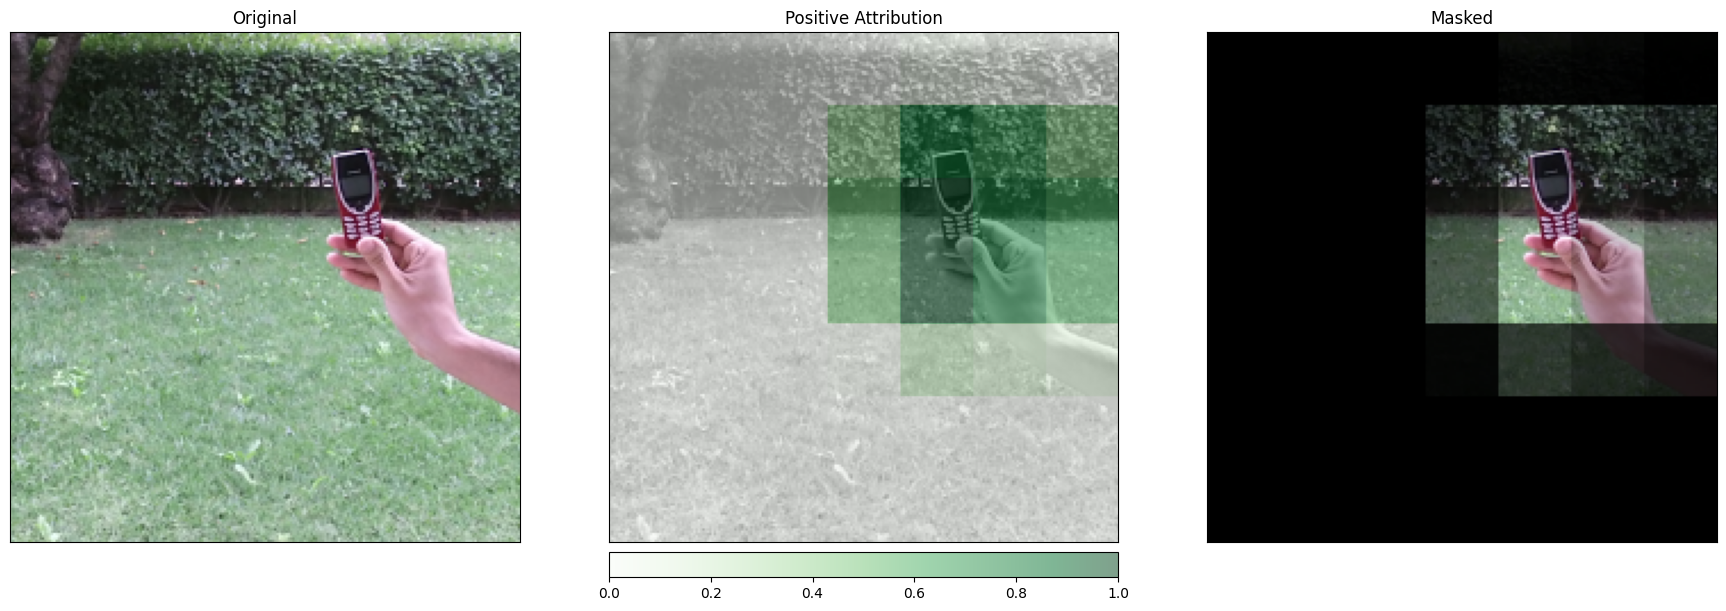

In [40]:
XAI(test_dataset,725)